In [ ]:
pip install alpha_vantage

In [ ]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

In [ ]:
#insert api key
api_key='O54P4FXU9KVQLANI'

#creating a time series object using api key
ts = TimeSeries(key=api_key, output_format='pandas')

# Fetch daily stock data for a specific stock (e.g., AAPL for Apple)
# You can adjust the 'outputsize' to 'compact' for the most recent data or 'full' for all historical data.
data, meta_data = ts.get_daily(symbol='JPM', outputsize='full')

In [ ]:
# Display the first few rows of the data
print(data.head())


            1. open   2. high   3. low  4. close  5. volume
date                                                       
2024-10-28   223.35  225.6400  222.950    225.50  6842956.0
2024-10-25   225.00  225.6200  220.875    222.31  6369720.0
2024-10-24   221.83  225.0600  221.660    224.98  6002202.0
2024-10-23   223.66  224.7999  222.530    223.41  6180528.0
2024-10-22   223.02  225.2800  221.100    224.12  9586793.0


In [ ]:
# Save the data to a CSV file for future use
data.to_csv('apple_stock_data.csv')

 Preprocessing dataset for **LSTM**

**1.Extract and Preprocess the 'close'**


For stock price prediction, we will typically use the 'close' prices to create our training data.

In [ ]:
# Extract only the '4. close' column, which is the target for prediction
close_prices = data['4. close'].values

# Reshape the data to 2D (required for scaling)
close_prices = close_prices.reshape(-1, 1)

# Normalize the data (scaling between 0 and 1)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Print the first few scaled values
print(scaled_data[:5])

[[1.        ]
 [0.98481314]
 [0.9975244 ]
 [0.99004999]
 [0.99343014]]


**2.Create sequence for LSTM**

LSTM requires sequential data. We need to create sequences of 60 days of stock prices to predict the next day’s stock price.

In [ ]:
import numpy as np

# Set the number of days for each sequence
sequence_length = 60

# Initialize empty lists to store sequences and corresponding labels
X_train = []
y_train = []

# Loop over the scaled data to create sequences
for i in range(sequence_length, len(scaled_data)):
    # Extract the sequence of 60 days
    X_train.append(scaled_data[i-sequence_length:i, 0])
    # The label is the next day’s stock price
    y_train.append(scaled_data[i, 0])

# Convert lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshape X_train to be 3D for LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (6228, 60, 1)
y_train shape: (6228,)


Import required libraries for performing LSTM

In [ ]:
pip install tensorflow

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Build the LSTM model

In [ ]:
# Initialize the LSTM model
model = Sequential()

# Add the first LSTM layer with 50 units and a dropout of 20%
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Add a second LSTM layer with 50 units and a dropout of 20%
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Add a third LSTM layer with 50 units and a dropout of 20%
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Add the output layer with 1 unit (since we are predicting the stock price)
model.add(Dense(units=1))

# Compile the model (using mean squared error loss and Adam optimizer)
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

**Train the LSTM Model**

Epoch 1/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - loss: 0.0106
Epoch 2/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 26s 103ms/step - loss: 0.0014
Epoch 3/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 0.0014
Epoch 4/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 0.0012
Epoch 5/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - loss: 9.3940e-04
Epoch 6/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 8.5584e-04
Epoch 7/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 100ms/step - loss: 8.0715e-04
Epoch 8/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 7.5077e-04
Epoch 9/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 21s 96ms/step - loss: 7.3585e-04
Epoch 10/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - loss: 6.5179e-04
Epoch 11/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 23s 106ms/step - loss: 6.4790e-04
Epoch 12/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 5.8180e-04
Epoch 13/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 22s 102ms/step - loss: 6.1222e-04
Epoch 14/100
195/195 ━━━━━━━━━━━━━━━━━━━━ 19

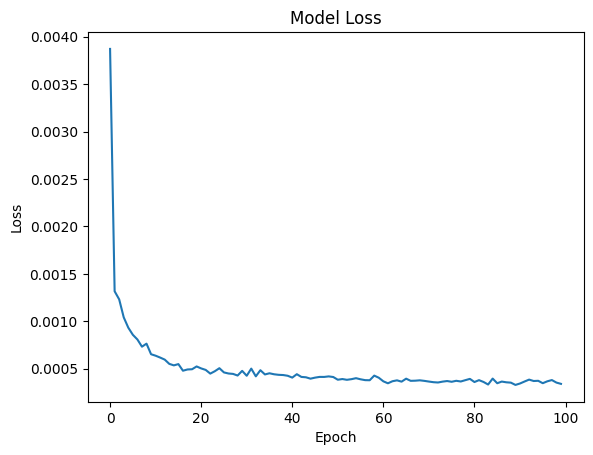

In [ ]:
# Train the model on the training data
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

# Plot the training loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


**Prepare the test data**

Once the model is trained, we need to prepare test data (unseen data) to evaluate the model.

In [ ]:
# Get the last 60 days from the training data
test_data = scaled_data[-60:]

# Reshape the test data for LSTM input (3D shape)
X_test = []
X_test.append(test_data)

# Convert to numpy array and reshape to 3D (samples, timesteps, features)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict the next day's stock price
predicted_price = model.predict(X_test)

# Inverse transform the scaled value back to the original price
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted Next Day's Stock Price: {predicted_price[0][0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
Predicted Next Day's Stock Price: 81.0068359375


**Prepare test data for evaluation**

To evaluate the model, we need to use data that wasn’t used for training. Let’s assume we are using the most recent portion of the dataset (e.g., the last 20% of the data) for testing.

In [ ]:
# Define the percentage of data to use for testing
test_size = int(len(scaled_data) * 0.2)

# Split the data into training and testing sets
train_data = scaled_data[:-test_size]
test_data = scaled_data[-test_size:]

# Prepare the test dataset: Create sequences of 60 days for the test set
X_test = []
y_test = []

# Loop over the test data to create sequences
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Convert the lists to numpy arrays
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape X_test to be 3D for LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")



X_test shape: (1197, 60, 1)
y_test shape: (1197,)


**Predict the stock price**

Now that we have the test data ready, let's predict the stock prices using the trained LSTM model.

In [ ]:
# Predict the stock prices on the test set
predicted_stock_prices = model.predict(X_test)

# Inverse transform the predicted values to the original price scale
predicted_stock_prices = scaler.inverse_transform(predicted_stock_prices)

# Inverse transform the true test values to the original scale
y_test = y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


**Visualize Predicted vs. Actual price**

Let's plot the actual stock prices and the predicted prices to visually compare the performance of the model.

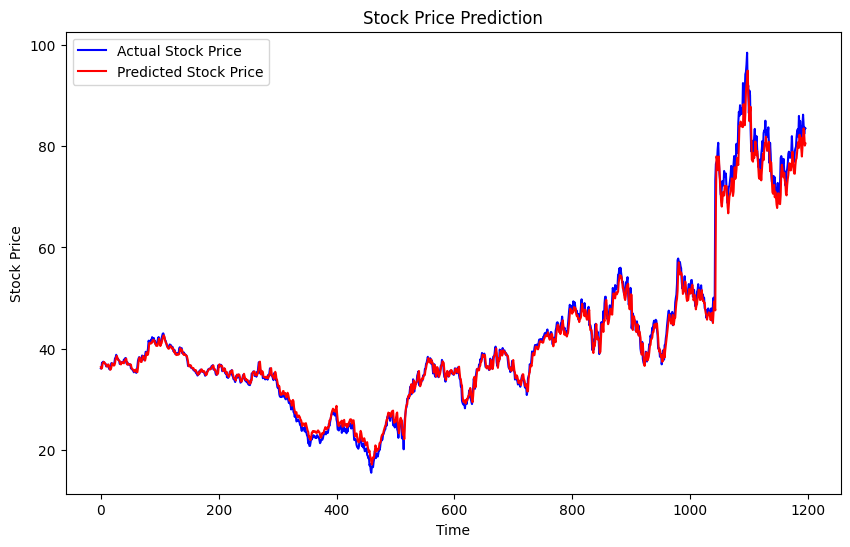

In [ ]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(y_test, color='blue', label='Actual Stock Price')
plt.plot(predicted_stock_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


**Evaluate model performance**

You can evaluate the model's performance using the Mean Squared Error (MSE) or Root Mean Squared Error (RMSE). The smaller the error, the better the model's prediction.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate MSE
mse = mean_squared_error(y_test, predicted_stock_prices)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 3.1074249485542094
Root Mean Squared Error: 1.7627889688088616


**Hyperparameter Tuning**

In [ ]:
# Define a function to create the model with hyperparameters
def create_lstm_model(units=50, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Example of training with different hyperparameters
model = create_lstm_model(units=64, dropout_rate=0.3)
history = model.fit(X_train, y_train, epochs=150, batch_size=32)


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0116
Epoch 2/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0015
Epoch 3/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0014
Epoch 4/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0013
Epoch 5/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0011
Epoch 6/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0011
Epoch 7/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.2702e-04
Epoch 8/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.0268e-04
Epoch 9/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 8.5957e-04
Epoch 10/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 8.1567e-04
Epoch 11/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.8013e-04
Epoch 12/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 7.2862e-04
Epoch 13/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 6.6374e-04
Epoch 14/150
195/195 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6.8106e-04
Epoch 15/

Tuning Strategies

To optimize your model, experiment with different tuning strategies:

Learning Rate Adjustment: Use a learning rate scheduler to reduce the learning rate as training progresses.

Early Stopping: Monitor the validation loss and stop training when it stops improving to prevent overfitting.

Batch Size and Epochs: Test different batch sizes and epochs to improve generalization.



In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler

# Calculate the 10-day SMA and drop NaN values
data['SMA_10'] = data['4. close'].rolling(window=10).mean()
data = data.dropna()

# Normalize both the closing price and the SMA feature
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['4. close', 'SMA_10']])

# Update sequence creation to include both closing price and SMA feature
sequence_length = 60
X_train = []
y_train = []
for i in range(sequence_length, len(scaled_data)):
    X_train.append(scaled_data[i-sequence_length:i, :])  # Include all features
    y_train.append(scaled_data[i, 0])  # Predicting closing price

# Convert to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)

# Confirm shape: should be (samples, timesteps, features)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Define and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.Dense(1)  # Output layer for predicting a single continuous value
])
model.compile(optimizer='adam', loss='mse')

# Learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00001)

# Fit the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[reduce_lr])


X_train shape: (6219, 60, 2)
y_train shape: (6219,)
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0260 - val_loss: 2.9448e-04 - learning_rate: 0.0010
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 3.1357e-04 - val_loss: 2.6307e-04 - learning_rate: 0.0010
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 2.8003e-04 - val_loss: 2.4299e-04 - learning_rate: 0.0010
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.5884e-04 - val_loss: 2.2378e-04 - learning_rate: 0.0010
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 2.4943e-04 - val_loss: 2.0821e-04 - learning_rate: 0.0010
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 2.4855e-04 - val_loss: 1.9638e-04 - learning_rate: 0.0010
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 1.9283e-04 - val_loss: 1.8909e-04 - learning_rate: 0.0010
Epoch 8/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 1.9805e-04 - val_loss: 1.6624e-04 - learning_rate: 0.0010
Epoch 9/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step -

**Adding New Feature**

In [ ]:
# Calculate the 20-day Exponential Moving Average (EMA)
data['EMA_20'] = data['4. close'].ewm(span=20, adjust=False).mean()

# Normalize the new feature and append it to the scaled data
ema_scaled = scaler.fit_transform(data['EMA_20'].values.reshape(-1, 1))
scaled_data = np.hstack((scaled_data, ema_scaled))

# Create sequences with the new feature for training and testing
X_train = []
y_train = []
for i in range(60, len(scaled_data)):
    X_train.append(scaled_data[i-60:i, :])  # Include the new feature
    y_train.append(scaled_data[i, 0])  # Predict the closing price

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

**Backtesting**

Once the model is trained and fine-tuned, perform backtesting to evaluate how the model would have performed if it had been used to make predictions in the past. This is crucial for stock market models to assess performance in real trading scenarios.

**Backtesting Logic**

You will simulate how the model would have made predictions for each day in the test dataset and compare them to the actual stock prices. If the predicted price is higher than the actual closing price, you can simulate a "buy" decision. If it's lower, simulate a "sell."

In [ ]:
initial_balance = 10000  # Starting balance in USD
balance = initial_balance
stock_owned = 0  # Number of stocks owned
for i in range(len(predicted_stock_prices)):
    # Buy stock if predicted price is higher than current
    if predicted_stock_prices[i] > y_test[i] and balance >= y_test[i]:
        stock_owned += balance // y_test[i]  # Buy as many stocks as possible
        balance %= y_test[i]  # Remaining balance after buying
    # Sell stock if predicted price is lower
    elif predicted_stock_prices[i] < y_test[i] and stock_owned > 0:
        balance += stock_owned * y_test[i]  # Sell all stocks
        stock_owned = 0

# Calculate final balance
final_balance = balance + stock_owned * y_test[-1]
print(f"Initial Balance: ${initial_balance}")
print(f"Final Balance after Backtesting: ${final_balance}")

Initial Balance: $10000
Final Balance after Backtesting: $[17264.6]


Evaluate model performance

Metrics Analysis:

Calculate evaluation metrics on the backtesting data, including:

Mean Squared Error (MSE)

Root Mean Squared Error (RMSE)

Mean Absolute Error (MAE)

R-squared (R²) score for accuracy.



In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

mse = mean_squared_error(y_test, predicted_stock_prices)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predicted_stock_prices)
r2 = r2_score(y_test, predicted_stock_prices)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 3.022655189671588
Root Mean Squared Error (RMSE): 1.7385784968391815
Mean Absolute Error (MAE): 1.2367765445119654
R² Score: 0.988838533925745


Visual Analysis:

Plot the predicted vs. actual prices to visually assess how well the model is predicting. Include error bands or residuals to highlight areas where the model deviates.

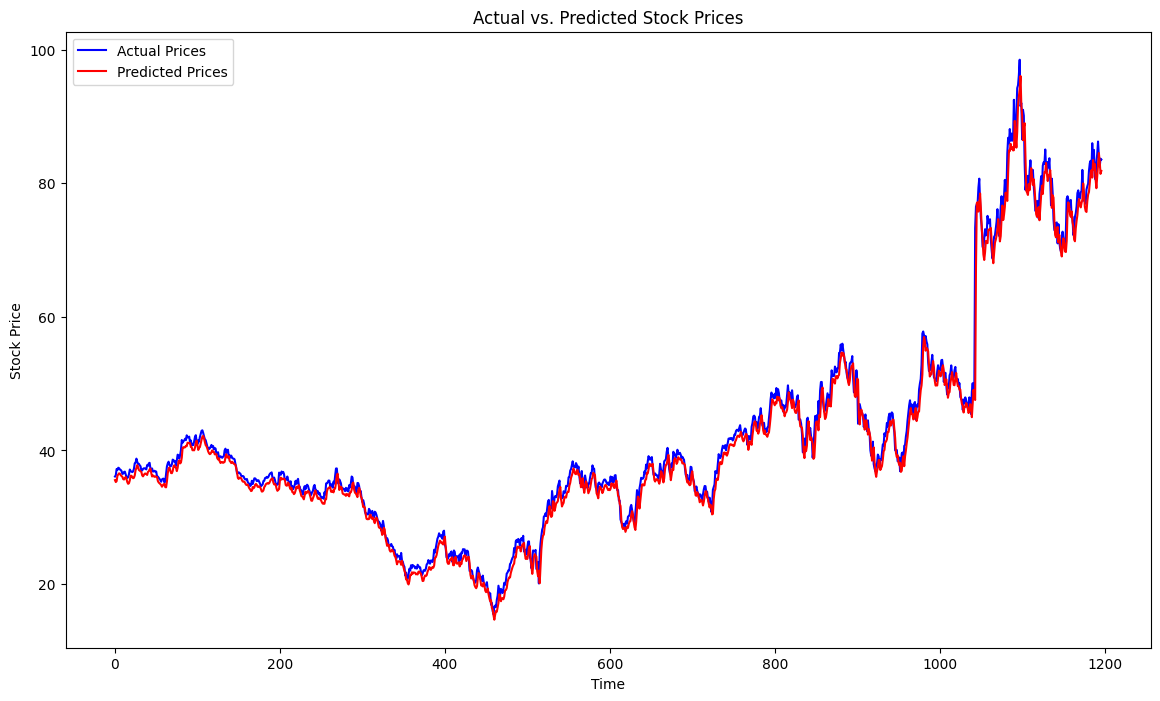

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(predicted_stock_prices, label='Predicted Prices', color='red')
plt.title('Actual vs. Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Model Fine-Tuning

Optimize Hyperparameters:

Experiment with different numbers of LSTM units, learning rates, batch sizes, epochs, etc.

Use tools like Grid Search or Random Search to systematically find the best hyperparameters.

In [ ]:
from sklearn.model_selection import GridSearchCV
def build_lstm_model(units=50, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model


Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best parameters found:  {'batch_size': 16, 'dropout_rate': 0.385244452888315, 'epochs': 30, 'learning_rate': 0.000624756431632238, 'units': 138}
Best score found:  -0.0011833472857315879


In [ ]:
pip install scikeras

In [ ]:
#from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor

model = KerasRegressor(build_fn=build_lstm_model, verbose=0)

In [ ]:
# Define the hyperparameters grid
param_grid = {
    'units': [50, 100, 150],  # Number of LSTM units
    'learning_rate': [0.001, 0.0005, 0.0001],  # Learning rates
    'batch_size': [16, 32, 64],  # Batch sizes
    'epochs': [50, 100, 150],  # Number of epochs
    'dropout_rate': [0.2, 0.3, 0.4]  # Dropout rates
}

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

# Fit GridSearchCV to the data
grid_result = grid.fit(X_train, y_train)

In [ ]:
# Display best parameters
print(f"Best Hyperparameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

In [ ]:
# Extract best hyperparameters
best_params = grid_result.best_params_

# Build the best model
best_model = build_lstm_model(
    units=best_params['units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate']
)

# Fit the model with the best hyperparameters
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.2)

Conduct a robust cross validation

Using k-fold cross-validation to evaluate model stability. This will give us a better understanding of how your model performs across different splits of the dataset.

In [ ]:
# Extract best hyperparameters
best_params = grid_result.best_params_

# Build the best model
best_model = build_lstm_model(
    units=best_params['units'],
    learning_rate=best_params['learning_rate'],
    dropout_rate=best_params['dropout_rate']
)

# Fit the model with the best hyperparameters
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.2)


In [ ]:
best_model.save('stock_lstm_model.h5')

Build an API for Predictions:

Use Flask or FastAPI to serve your model and make it accessible for real-time predictions.

In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import numpy as np

app = Flask(__name__)
model = load_model('stock_lstm_model.h5')

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    input_data = np.array(data['input']).reshape((1, 60, 2))  # Adjust shape based on input
    prediction = model.predict(input_data)
    return jsonify({'prediction': prediction[0][0]})

if __name__ == '__main__':
    app.run(debug=True)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'stock_lstm_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)